# FIAP Bootcamp - Wtec Suprimentos - Sugestão de Limite
Case: **Wtec Suprimentos - Análise de Crédito**\
Turma: **1IAR**

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Claudio Manuel           | RM 346353      | 1IAR |
| Jonas Zarpellon          | RM 345724      | 1IAR |
| Rafael Yuji              | RM 346108      | 1IAR |

## Introdução

### Problema Proposto - Parte 4-B: Sugestão de Limite de Crédito
- A empresa deseja, entre outras coisas, criar um 'robö automatizado' (na linguagem da propria empresa), que realize uma recomendacäo de crédito para que os analistas se baseiem nessa recomendacäo para conceder o limite måximo de crédito.
- Vale salientar que por se tratar de valores monetérios é importante que este modelo tenha um bom desempenho

### Abordagem Proposta
- O objetivo desta modelagem é treinar um algoritmo de aprendizado capaz de sugerir um limite de crédito para um cliente
- Será utilizado um algoritmo supervisionado para essa regressão, baseado nos limites atribuidos aos clientes na base de dados histórica
- Será explorada somente a hipótese 2, utilizando as informações disponíveis nas documentações contábeis

### Setup

In [1]:
# dados / io
import pandas as pd
import pandas_flavor as pf
import numpy as np
import joblib
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# otimização
from sklearnex import patch_sklearn
patch_sklearn()
# preprocessamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
# machine learning
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from xgboost import XGBRegressor
# deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization
from tensorflow.keras.utils import plot_model
# seleção de modelos
import optuna as opt
opt.logging.set_verbosity(opt.logging.WARNING)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    r2_score, mean_absolute_percentage_error, median_absolute_error, \
    mean_gamma_deviance
from sklearn.inspection import permutation_importance
# display
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=opt.exceptions.ExperimentalWarning)
pd.options.display.float_format = '{:,.4f}'.format


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Carga de Dados

In [2]:
data = pd.read_csv('solicitacoescredito_segmentada.csv')
data.sample(5).T

,2618,8154,1363,771,6551
numero_solicitacao,"2,691.0000","8,227.0000","1,405.0000",795.0000,"6,624.0000"
razaoSocial,Ms. Tina Moore,Aimee Burke,Justin Perkins,Vincent Green,Helen Dean-Miller
nomeFantasia,Jake Roberts-Dale,Dr. Edward Stevenson,Leanne Perry,Henry White,Carolyn Sutton-Morris
cnpjSemTraco,BLOV31449361909433,FWFK37150478327468,XYVX24702043102303,BXBG58832105546134,YPBV53942632372249
maiorAtraso,3,15,5,5,4
margemBrutaAcumulada,0.4188,0.4295,0.0000,0.5631,0.5484
percentualProtestos,0.0000,0.0000,NaN,0.0000,0.0000
primeiraCompra,2015-06-12T00:00:00,2006-06-26T00:00:00,2017-09-27T08:40:26,2019-05-31T00:00:00,2018-03-21T00:00:00
prazoMedioRecebimentoVendas,56,0,0,3,26
titulosEmAberto,"5,777.8000","297,070.0400",0.0000,"55,199.8400","15,300.0000"


### Pre-Processamento

#### filtro

In [3]:
# filtra as solicitações aprovadas
@pf.register_dataframe_method
def filter_status(
	data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X = X[X.status.isin(['AprovadoAnalista', 'AprovadoComite'])]
	X = X[X.anoFundacao > 1900]
	X = X[X.faturamentoBruto > 0]
	X = X[X.valorAprovado > 0]
	X = X[X.periodoDemonstrativoEmMeses > 0]
	X = X[X.cluster.notna()]
	return X
data.filter_status().describe().T

,count,mean,std,min,25%,50%,75%,max
numero_solicitacao,"6,627.0000","4,758.5695","2,538.1402",1.0000,"2,678.0000","4,853.0000","6,946.5000","9,034.0000"
maiorAtraso,"6,627.0000",23.9031,63.8556,0.0000,3.0000,6.0000,21.0000,977.0000
margemBrutaAcumulada,"6,627.0000",0.3734,0.1950,0.0000,0.2992,0.4123,0.5123,1.0000
percentualProtestos,"5,642.0000",0.0155,0.5807,0.0000,0.0000,0.0000,0.0000,36.9837
prazoMedioRecebimentoVendas,"6,627.0000",23.5636,65.7522,0.0000,0.0000,0.0000,32.0000,"1,605.0000"
titulosEmAberto,"6,627.0000","52,004.6309","186,453.5425",0.0000,0.0000,0.0000,"17,352.2400","2,836,656.0000"
valorSolicitado,"6,627.0000","272,188.0506","7,382,539.2892","3,000.0000","25,000.0000","50,000.0000","100,000.0000","600,000,000.0000"
diferencaPercentualRisco,"6,627.0000",0.7411,0.1251,0.2642,0.6604,0.7500,0.8491,1.0000
percentualRisco,"6,627.0000",0.2589,0.1251,0.0000,0.1509,0.2500,0.3396,0.7358
dashboardCorrelacao,"6,627.0000",0.0427,0.4915,-1.0000,0.0000,0.0000,0.0000,0.9999


#### feature engineering

In [4]:
# gera as features calculadas sem usar as colunas de documentação
@pf.register_dataframe_method
def engineer(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X['faturamentoMensal'] = X.faturamentoBruto / X.periodoDemonstrativoEmMeses
	X['margemMensal'] = X.margemBruta / X.periodoDemonstrativoEmMeses
	X['margem_percentual'] = (X.margemMensal / X.faturamentoMensal).replace([np.inf, np.NINF], np.nan)
	X['dt_dataAprovadoNivelAnalista'] = pd.to_datetime(X.dataAprovadoNivelAnalista, errors='coerce')
	X['dt_primeiraCompra'] = pd.to_datetime(X.primeiraCompra, errors='coerce')
	X['tempoPrimeiraCompra'] = (X.dt_dataAprovadoNivelAnalista - X.dt_primeiraCompra).dt.days
	return X

data.filter_status().engineer().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 8961
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   numero_solicitacao            6627 non-null   float64       
 1   razaoSocial                   6627 non-null   object        
 2   nomeFantasia                  6627 non-null   object        
 3   cnpjSemTraco                  6627 non-null   object        
 4   maiorAtraso                   6627 non-null   int64         
 5   margemBrutaAcumulada          6627 non-null   float64       
 6   percentualProtestos           5642 non-null   float64       
 7   primeiraCompra                6627 non-null   object        
 8   prazoMedioRecebimentoVendas   6627 non-null   int64         
 9   titulosEmAberto               6627 non-null   float64       
 10  valorSolicitado               6627 non-null   float64       
 11  status                        

#### seleção de features

In [5]:
# seleciona as features relevantes
@pf.register_dataframe_method
def select(
  data: pd.DataFrame,
  identifier: bool = False,
) -> pd.DataFrame:
	X = data.copy()
	keep = [
			'percentualRisco',
			# 'valorAprovado',
			# 'limiteEmpresaAnaliseCredito',
			'limiteCredito',
			'faturamentoMensal',
			'anoFundacao',
			'restricoes',
			'empresa_MeEppMei',
			'scorePontualidade',
			'margem_percentual',
			'maiorAtraso',
			'tempoPrimeiraCompra',
			'prazoMedioRecebimentoVendas',
			'cluster',
		]
	if identifier:
		keep = keep + ['numero_solicitacao']
	intersection = list(set(data.columns).intersection(set(keep)))
	return X[intersection]
data.filter_status().engineer().select().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 8961
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   scorePontualidade            6627 non-null   float64
 1   prazoMedioRecebimentoVendas  6627 non-null   int64  
 2   faturamentoMensal            6627 non-null   float64
 3   maiorAtraso                  6627 non-null   int64  
 4   percentualRisco              6627 non-null   float64
 5   limiteCredito                6627 non-null   float64
 6   restricoes                   6627 non-null   object 
 7   anoFundacao                  6627 non-null   float64
 8   tempoPrimeiraCompra          6627 non-null   int64  
 9   cluster                      6627 non-null   float64
 10  margem_percentual            6627 non-null   float64
 11  empresa_MeEppMei             6627 non-null   object 
dtypes: float64(7), int64(3), object(2)
memory usage: 673.1+ KB


#### remoção de outliers

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
- por se tratarem de dados reais, apresentam muito ruído o que gera forte impacto no resultado dos modelos e dificulta a capacidade de generalização <br>
- optou-se por remover os outliers mais significativos da base de dados antes do treinamento <br>
- foram combinadas 4 técnicas para identificação de outliers: Isolation Forest, Local Outlier Factor, One Class SVM e Robust Covariance
</td></tr></table></div>

In [6]:
@pf.register_dataframe_method
def remove_outliers(
        data: pd.DataFrame,
    ) -> pd.DataFrame:    
    X = data.copy()
    # gera uma copia nao modificada dos dados
    Z = X.copy()
    # treina um modelo de Isolation Forest
    model_if = IsolationForest(contamination=0.05)
    X['outlier_if'] = model_if.fit_predict(Z)
    # treina um modelo Local Outlier Factor
    model_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  
    X['outlier_lof'] = model_lof.fit_predict(Z)
    # treina um modelo One Class SVM   
    model_ocsvm = OneClassSVM(nu=0.05)
    X['outlier_ocsvm'] = model_ocsvm.fit_predict(Z)
    # treina um modelo de Robust Covariance
    model_rc = EllipticEnvelope(contamination=0.05, support_fraction=0.2)
    X['outlier_rc'] = model_rc.fit_predict(Z)
    # remove os outliers
    X = X[X.outlier_if != -1]
    X = X[X.outlier_lof != -1]
    X = X[X.outlier_ocsvm != -1]
    X = X[X.outlier_rc != -1]
    X = X.drop(columns = ['outlier_if', 'outlier_lof', 'outlier_ocsvm', 'outlier_rc'])
    return X
d = data.filter_status().engineer().select().remove_outliers()
print (f'Outliers removidos: {d.shape[0] - d.remove_outliers().shape[0]}')


Outliers removidos: 744


#### encoding das categorias

In [7]:
# realiza o one-hot encoding do cluster
@pf.register_dataframe_method
def encode(
		data: pd.DataFrame,
		features: list,
		) -> pd.DataFrame:
	X = data.copy()
	for feature in features:
		X = pd.get_dummies(X[feature], prefix=feature).join(X)
		X = X.drop(columns=[feature])
	return X
data.filter_status().engineer().select().encode(['cluster']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 8961
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster_0.0                  6627 non-null   uint8  
 1   cluster_1.0                  6627 non-null   uint8  
 2   cluster_2.0                  6627 non-null   uint8  
 3   cluster_3.0                  6627 non-null   uint8  
 4   cluster_4.0                  6627 non-null   uint8  
 5   cluster_5.0                  6627 non-null   uint8  
 6   scorePontualidade            6627 non-null   float64
 7   prazoMedioRecebimentoVendas  6627 non-null   int64  
 8   faturamentoMensal            6627 non-null   float64
 9   maiorAtraso                  6627 non-null   int64  
 10  percentualRisco              6627 non-null   float64
 11  limiteCredito                6627 non-null   float64
 12  restricoes                   6627 non-null   object 
 13  anoFundacao       

#### data types

In [8]:
# converte data types
@pf.register_dataframe_method
def type_cast(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X = X.astype('float32')		
	return X
data.filter_status().engineer().select().encode(['cluster']).type_cast().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 8961
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster_0.0                  6627 non-null   float32
 1   cluster_1.0                  6627 non-null   float32
 2   cluster_2.0                  6627 non-null   float32
 3   cluster_3.0                  6627 non-null   float32
 4   cluster_4.0                  6627 non-null   float32
 5   cluster_5.0                  6627 non-null   float32
 6   scorePontualidade            6627 non-null   float32
 7   prazoMedioRecebimentoVendas  6627 non-null   float32
 8   faturamentoMensal            6627 non-null   float32
 9   maiorAtraso                  6627 non-null   float32
 10  percentualRisco              6627 non-null   float32
 11  limiteCredito                6627 non-null   float32
 12  restricoes                   6627 non-null   float32
 13  anoFundacao       

#### limpeza

In [9]:
# elimina valores nulos
@pf.register_dataframe_method
def clean(
  data: pd.DataFrame,
) -> pd.DataFrame:
	return data.dropna()
data.filter_status().engineer().select().encode(['cluster']).type_cast().clean().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 8961
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster_0.0                  6627 non-null   float32
 1   cluster_1.0                  6627 non-null   float32
 2   cluster_2.0                  6627 non-null   float32
 3   cluster_3.0                  6627 non-null   float32
 4   cluster_4.0                  6627 non-null   float32
 5   cluster_5.0                  6627 non-null   float32
 6   scorePontualidade            6627 non-null   float32
 7   prazoMedioRecebimentoVendas  6627 non-null   float32
 8   faturamentoMensal            6627 non-null   float32
 9   maiorAtraso                  6627 non-null   float32
 10  percentualRisco              6627 non-null   float32
 11  limiteCredito                6627 non-null   float32
 12  restricoes                   6627 non-null   float32
 13  anoFundacao       

#### padronização

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
foi utilizada a padronização por min-max, para manter todos os valores positivos durante o treinamento. isso ajudou a evitar erros no cáculo da métrica de variação gamma
</td></tr></table></div>

In [10]:
# aplica padronização por z-score
@pf.register_dataframe_method
def standardize(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	# clip outliers
	# X = X.clip(lower=X.quantile(0.01), upper=X.quantile(0.99), axis=1)
	standardizer = MinMaxScaler(feature_range = (0, 1))
	X = pd.DataFrame(standardizer.fit_transform(X), columns=X.columns)
	return X
data.filter_status().engineer().select().encode(['cluster']).type_cast().clean().standardize().describe().T

,count,mean,std,min,25%,50%,75%,max
cluster_0.0,"6,627.0000",0.5055,0.5000,0.0000,0.0000,1.0000,1.0000,1.0000
cluster_1.0,"6,627.0000",0.0552,0.2284,0.0000,0.0000,0.0000,0.0000,1.0000
cluster_2.0,"6,627.0000",0.2983,0.4576,0.0000,0.0000,0.0000,1.0000,1.0000
cluster_3.0,"6,627.0000",0.0035,0.0588,0.0000,0.0000,0.0000,0.0000,1.0000
cluster_4.0,"6,627.0000",0.0567,0.2314,0.0000,0.0000,0.0000,0.0000,1.0000
cluster_5.0,"6,627.0000",0.0807,0.2724,0.0000,0.0000,0.0000,0.0000,1.0000
scorePontualidade,"6,627.0000",0.8222,0.3589,0.0000,0.9268,1.0000,1.0000,1.0000
prazoMedioRecebimentoVendas,"6,627.0000",0.0147,0.0410,0.0000,0.0000,0.0000,0.0199,1.0000
faturamentoMensal,"6,627.0000",0.0096,0.0541,0.0000,0.0003,0.0007,0.0031,1.0000
maiorAtraso,"6,627.0000",0.0245,0.0654,0.0000,0.0031,0.0061,0.0215,1.0000


#### preparação dos dados

In [11]:
data_preprocess = data.filter_status().engineer().select().remove_outliers().encode(['cluster']).type_cast().clean()
targets_preprocess = data_preprocess['limiteCredito']
features_preprocess = data_preprocess.drop(columns=['limiteCredito']).standardize()

data_train, data_test, targets_train, targets_test = train_test_split(features_preprocess, targets_preprocess, test_size=0.2, random_state=42)

display(data_train.info())
display(data_train.describe().T)
print (f'Shape de data_train: {data_train.shape}')
print (f'Shape de data_test: {data_test.shape}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4615 entries, 2377 to 860
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster_0.0                  4615 non-null   float32
 1   cluster_1.0                  4615 non-null   float32
 2   cluster_2.0                  4615 non-null   float32
 3   cluster_3.0                  4615 non-null   float32
 4   cluster_4.0                  4615 non-null   float32
 5   cluster_5.0                  4615 non-null   float32
 6   scorePontualidade            4615 non-null   float32
 7   prazoMedioRecebimentoVendas  4615 non-null   float32
 8   faturamentoMensal            4615 non-null   float32
 9   maiorAtraso                  4615 non-null   float32
 10  percentualRisco              4615 non-null   float32
 11  restricoes                   4615 non-null   float32
 12  anoFundacao                  4615 non-null   float32
 13  tempoPrimeiraCom

None

,count,mean,std,min,25%,50%,75%,max
cluster_0.0,"4,615.0000",0.5135,0.4999,0.0000,0.0000,1.0000,1.0000,1.0000
cluster_1.0,"4,615.0000",0.0314,0.1745,0.0000,0.0000,0.0000,0.0000,1.0000
cluster_2.0,"4,615.0000",0.3222,0.4674,0.0000,0.0000,0.0000,1.0000,1.0000
cluster_3.0,"4,615.0000",0.0030,0.0550,0.0000,0.0000,0.0000,0.0000,1.0000
cluster_4.0,"4,615.0000",0.0583,0.2343,0.0000,0.0000,0.0000,0.0000,1.0000
cluster_5.0,"4,615.0000",0.0715,0.2577,0.0000,0.0000,0.0000,0.0000,1.0000
scorePontualidade,"4,615.0000",0.8452,0.3367,0.0000,0.9597,1.0000,1.0000,1.0000
prazoMedioRecebimentoVendas,"4,615.0000",0.0138,0.0374,0.0000,0.0000,0.0000,0.0193,1.0000
faturamentoMensal,"4,615.0000",0.0585,0.1161,0.0000,0.0053,0.0140,0.0512,1.0000
maiorAtraso,"4,615.0000",0.0306,0.0620,0.0000,0.0048,0.0095,0.0318,1.0000


Shape de data_train: (4615, 16)
Shape de data_test: (1154, 16)


### Treinamento dos Modelos

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
- foram testados 4 algoritmos, incluindo uma rede neural <br>
- para cada algoritmo, foram testadas as principais variações dos seus hiperparâmetros<br>
- a busca foi feita por otimização bayesiana, utilizando validação cruzada com 5 partições <br>
- no caso da rede neural foi realizado uma validação simples com split de 20% <br>
- todas as métricas de avaliação foram feitas no conjunto de teste (holdout) <br>
- o particionamento do conjunto de teste foi feito com 20% dos registros disponíveis
</td></tr></table></div>

#### rotinas de otimização

In [12]:
# callback para salvar o melhor modelo
def callback(
		study: opt.study.Study,
		trial: opt.trial.FrozenTrial,
	) -> None:
	if study.best_trial.number == trial.number:
		study.set_user_attr(key='best_estimator', value=trial.user_attrs['estimator'])

In [13]:
# plota os resultados da otimização e a avaliação do melhor modelo no dataset de teste
def plot_optimization_results(
		study: opt.study.Study,
		y_test: pd.DataFrame,
		y_pred: np.ndarray,
	) -> None:

	# plota os resultados da otimização
	display(opt.visualization.plot_optimization_history(study))
	try:
		display(opt.visualization.plot_param_importances(study))
	except:
		...
	
	# imprime o melhor modelo
	print (f'Best trial: {study.best_trial.value}')
	print (f'Best parameters: {study.best_params}')

In [14]:
# rotina de otimização bayesiana
def optimize(
		objective, #Callable,
    description: str,
    n_trials: int,
		X: pd.DataFrame,
		y: pd.DataFrame,
		X_test: pd.DataFrame,
		y_test: pd.DataFrame,
	) -> dict: 
        
	# cria o estudo e executa a otimização
	study = opt.create_study(direction='maximize')
	study.optimize(lambda trial:objective(trial, X, y),
		callbacks=[callback], n_trials=n_trials, timeout=60*5, n_jobs=-1, show_progress_bar = True)

	# fita e salva o melhor modelo
	fit = study.user_attrs['best_estimator'].fit(X, y)
	joblib.dump(fit, f'models/{description}.joblib')

	# avalia os resultados no conjunto de teste
	y_pred_val = fit.predict(X)
	y_pred = fit.predict(X_test)

	p = pd.DataFrame(y_pred, columns=['y_pred'])
	p = p[p.y_pred <= 0]
	display(p)

	pv = pd.DataFrame(y_pred_val, columns=['y_pred_val'])
	pv = pv[pv.y_pred_val <= 0]
	display(pv)
	
	t = pd.DataFrame(y_test, columns=['y_test'])
	t = t[t.y_test <= 0]
	display(t)

	tv = pd.DataFrame(y, columns=['y'])
	tv = tv[tv.y <= 0]
	display(tv)

	metrics = {
		'validation': {
			'mae': mean_absolute_error(y, y_pred_val),
			'rmse': np.sqrt(mean_squared_error(y, y_pred_val)),
			'median_error': median_absolute_error(y, y_pred_val),
			'r2': r2_score(y, y_pred_val),
			'mape': mean_absolute_percentage_error(y, y_pred_val),
			'gamma_deviance': mean_gamma_deviance(y, y_pred_val),
		},
		'test': {
			'mae': mean_absolute_error(y_test, y_pred),
			'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
			'median_error': median_absolute_error(y, y_pred_val),
			'r2': r2_score(y_test, y_pred),
			'mape': mean_absolute_percentage_error(y_test, y_pred),
			'gamma_deviance': mean_gamma_deviance(y_test, y_pred),
		}
	}
	validation = pd.DataFrame(metrics['validation'], index=['validation'])
	test = pd.DataFrame(metrics['test'], index=['test'])
	display(pd.concat([validation, test], axis=0).T)

	# plota os resultados
	plot_optimization_results(study, y_test, y_pred)
	
	return {
		'description': description,
		'metrics': metrics,
		'estimator': fit,
		'results': study.trials_dataframe(),
		'predictions': y_pred,
	}

models = {}

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
- foi utilizado o MAPE como métrica de avaliação <br>
- o objetivo definido foi minimizar a métrica gamma_deviance <br>
- essas métricas avaliam os erros percentuais e são invariantes com relação à escala dos valores, por esse motivo induzem a um aprendizado que gera erros percentuais uniformes <br>
- a estratégia, dessa forma, é evitar que o modelo erre mais em valores maiores ou menores, mantendo um erro relativo constante
</td></tr></table></div>

#### árvore de regressão

In [15]:
# define o espaço de busca e a função objetivo
def objective_regression_tree(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	estimator = DecisionTreeRegressor(
		criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
		min_samples_split = trial.suggest_int('min_samples_split', 2, 100),
		min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100),
	)
	trial.set_user_attr(key='estimator', value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='neg_mean_gamma_deviance')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
regression_tree_model = optimize(
	objective=objective_regression_tree, 
	description='regression_tree_risk', n_trials=300,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

models[regression_tree_model['description']] = regression_tree_model

  0%|          | 0/300 [00:00<?, ?it/s]

,y_pred


,y_pred_val


,y_test


,y


,validation,test
mae,"63,407.9429","70,956.6759"
rmse,"158,396.5560","167,120.8426"
median_error,"14,222.3013","14,222.3013"
r2,0.7161,0.6682
mape,0.7600,0.9045
gamma_deviance,0.3446,0.4827


Best trial: -0.5058057396058946
Best parameters: {'criterion': 'poisson', 'min_samples_split': 5, 'min_samples_leaf': 21}


#### random forest

In [16]:
# define o espaço de busca e a função objetivo
def objective_random_forests(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	estimator = RandomForestRegressor(
		criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
		min_samples_split = trial.suggest_int('min_samples_split', 2, 100),
		min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100),
	)
	trial.set_user_attr(key='estimator', value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='neg_mean_gamma_deviance')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
random_forest_model = optimize(
	objective=objective_random_forests, 
	description='random_forests_risk', n_trials=100,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

models[random_forest_model['description']] = random_forest_model

  0%|          | 0/100 [00:00<?, ?it/s]

,y_pred


,y_pred_val


,y_test


,y


,validation,test
mae,"23,210.7832","47,141.1992"
rmse,"62,400.4023","111,179.3828"
median_error,"5,449.7812","5,449.7812"
r2,0.9559,0.8531
mape,0.3147,0.6879
gamma_deviance,0.0995,0.2923


Best trial: -0.3372527897357941
Best parameters: {'criterion': 'squared_error', 'min_samples_split': 3, 'min_samples_leaf': 2}


#### xgboost - dart

In [17]:
# define o espaço de busca e a função objetivo
def xgboost_regressor_dart(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	hyperparameters = {
		# 'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
		'booster': 'dart',
		'objective': 'reg:gamma',
		'eval_metric': 'mape',
		'verbosity': 0,
		'alpha': trial.suggest_float('alpha', 1e-1, 1.0, log=True),
		'lambda': trial.suggest_float('lambda', 1e-1, 1.0, log=True),
		'eta': trial.suggest_float('eta', 1e-10, 1.0, log=True),
		'max_depth': trial.suggest_int('max_depth', 1, 9),
		'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
		'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
		'gamma': trial.suggest_float('gamma', 1e-8, 1e8, log=True),
		'sample_type': trial.suggest_categorical('sample_type', ['uniform', 'weighted']),
		'normalize_type': trial.suggest_categorical('normalize_type', ['tree', 'forest']),
		'rate_drop': trial.suggest_float('rate_drop', 1e-8, 1.0, log=True),
		'skip_drop': trial.suggest_float('skip_drop', 1e-8, 1.0, log=True),
		'updater': trial.suggest_categorical('updater', ['coord_descent', 'shotgun']),
		'feature_selector': trial.suggest_categorical('feature_selector', ['cyclic', 'shuffle']),
	}
	hp = {
		'booster': hyperparameters['booster'],
		'objective': hyperparameters['objective'],
		'eval_metric': hyperparameters['eval_metric'],
		'verbosity': hyperparameters['verbosity'],
	}
	
	if hyperparameters['booster'] in ['gbtree', 'dart']:
		# L1 regularization term on weights. Increasing this value will make model more conservative.
		hp['alpha'] = hyperparameters['alpha']
		# L2 regularization term on weights. Increasing this value will make model more conservative.
		hp['lambda'] = hyperparameters['lambda']
		# Step size shrinkage used in update to prevents overfitting
		hp['eta'] = hyperparameters['eta']
		# maximum depth of the tree, signifies complexity of the tree.
		hp['max_depth'] = hyperparameters['max_depth']
		# Controls a way new nodes are added to the tree.
		hp['grow_policy'] = hyperparameters['grow_policy']
		# minimum child weight, larger the term more conservative the tree.
		hp['min_child_weight'] = hyperparameters['min_child_weight']
		# defines how conservative algorithm is.
		hp['gamma'] = hyperparameters['gamma']

	if hyperparameters['booster'] == 'dart':
		# sampling ratio for dropout.
		hp['sample_type'] = hyperparameters['sample_type']
		# Type of normalization algorithm
		hp['normalize_type'] = hyperparameters['normalize_type']
		# Dropout rate (a fraction of previous trees to drop during the dropout)
		hp['rate_drop'] = hyperparameters['rate_drop']
		# Probability of skipping the dropout procedure during a boosting iteration.
		hp['skip_drop'] = hyperparameters['skip_drop']

	if hyperparameters['booster'] == 'gblinear':
		# algorithm to fit linear model
		hp['updater'] = hyperparameters['updater']
		# feature selector
		hp['feature_selector'] = hyperparameters['feature_selector']

	estimator = XGBRegressor(**hp)
	trial.set_user_attr(key='estimator', value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='neg_mean_gamma_deviance')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
xgboost_model_dart = optimize(
	objective=xgboost_regressor_dart, 
	description='xgboost_dart_risk', n_trials=200,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

models[xgboost_model_dart['description']] = xgboost_model_dart

  0%|          | 0/200 [00:00<?, ?it/s]

,y_pred


,y_pred_val


,y_test


,y


,validation,test
mae,"22,145.4199","43,572.4844"
rmse,"59,074.4922","119,635.9688"
median_error,"6,078.9355","6,078.9355"
r2,0.9605,0.8299
mape,0.2467,0.4416
gamma_deviance,0.0798,0.3100


Best trial: -0.3449609041213989
Best parameters: {'alpha': 0.9495742864473932, 'lambda': 0.9074272362843034, 'eta': 0.29035670909072064, 'max_depth': 7, 'grow_policy': 'lossguide', 'min_child_weight': 6, 'gamma': 2.8597618345009086e-08, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.740721940704204e-06, 'skip_drop': 1.511994784674324e-06, 'updater': 'shotgun', 'feature_selector': 'shuffle'}


#### rede neural MLP

In [34]:
# utiliza early stopping para parar o treinamento quando não houver mais melhora
# retorna o melhor modelo salvo pelo checkpoint
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    min_delta=0.1,
    patience=200,
    verbose=0,
    restore_best_weights=True,
)

In [35]:
def hypermodel(hp):
	# implementa um modelo sequencial
	model = Sequential()
	# adiciona uma camada de entrada
	model.add(Input(shape=(data_train.shape[1])))
	# escala do modelo
	scale = hp.Int('scale', min_value=1, max_value=12, step=1)
	# profundidade do modelo
	depth = hp.Int('depth', min_value=2, max_value=4, step=1)
	# formato do modelo
	shape = hp.Choice('shape', ['linear', 'growing', 'shrinking'])
	# dropout 
	dropout = hp.Float('dropout', min_value=0.35, max_value=0.55, step=0.05)
	# calcula o numero total de neuronios
	total_neurons = scale * 1000
	# gera a distribuição de neuronios conforme o formato
	if shape == 'linear':
		neurons = [total_neurons // depth] * depth
	elif shape == 'shrinking':
		neurons = [int(total_neurons/2**(i+1)) for i in range(depth)]
	elif shape == 'growing':
		# reverse
		neurons = [int(total_neurons/2**(i+1)) for i in range(depth)]
		neurons.reverse()
	# adiciona as camadas ocultas
	for i in range(depth):
		model.add(Dense(neurons[i], activation='relu'))
		model.add(Dropout(dropout))
	# adiciona uma camada de saída
	model.add(Dense(1))
	# compila o modelo
	loss = 'mean_absolute_percentage_error'
	model.compile(
		# loss='mean_absolute_percentage_error',
		loss=loss,
		optimizer='adam',
		metrics=['mean_absolute_percentage_error', 'mean_squared_error', 'mean_absolute_error'])
	return model

In [39]:
optimizer = BayesianOptimization(
	hypermodel = hypermodel,
	objective = 'val_loss',
	max_trials = 100,
	executions_per_trial=1, 
	directory = 'search',	
	project_name = 'limite_risco_2',
	overwrite = False,
	num_initial_points = 10,
	beta = 2.6, 
)

optimizer.search_space_summary()

Search space summary
Default search space size: 4
scale (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 12, 'step': 1, 'sampling': 'linear'}
depth (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
shape (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'growing', 'shrinking'], 'ordered': False}
dropout (Float)
{'default': 0.35, 'conditions': [], 'min_value': 0.35, 'max_value': 0.55, 'step': 0.05, 'sampling': 'linear'}


In [37]:
features_train_nn, features_val_nn, targets_train_nn, targets_val_nn = train_test_split(data_train, targets_train, test_size=0.2, random_state=42)

In [ ]:
# realiza a busca
optimizer.search(
	features_train_nn,
	targets_train_nn,
  epochs=2500,
  batch_size=8000,
  validation_data=(features_val_nn, targets_val_nn),
  callbacks=[early_stopping],
  verbose=1,
)

{'scale': 3, 'depth': 3, 'shape': 'linear', 'dropout': 0.5}
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 1000)              17000     
                                                                 
 dropout_54 (Dropout)        (None, 1000)              0         
                                                                 
 dense_70 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_55 (Dropout)        (None, 1000)              0         
                                                                 
 dense_71 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_56 (Dropout)        (None, 1000)              0         
                                                           

None

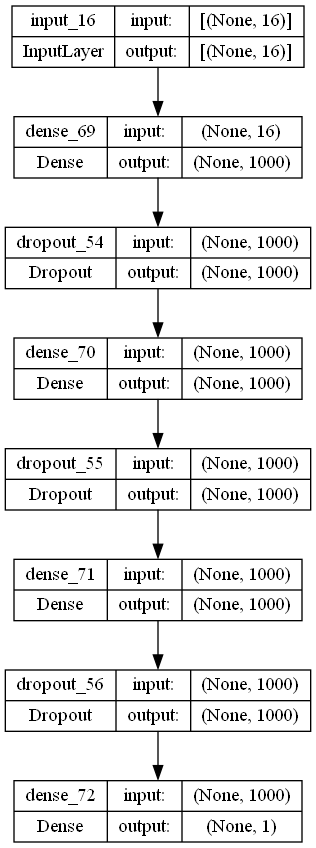

In [96]:
from kerastuner.engine.hyperparameters import HyperParameters
best_hp = optimizer.get_best_hyperparameters()[0]
# após a busca, foram fixados os melhores valores abaixo
best_hp = HyperParameters()
best_hp.values = {'scale': 3, 'depth': 3, 'shape': 'linear', 'dropout': 0.5}
print(best_hp.values)
mlp_model = hypermodel(best_hp)
display(mlp_model.summary())
# plot model
plot_model(mlp_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

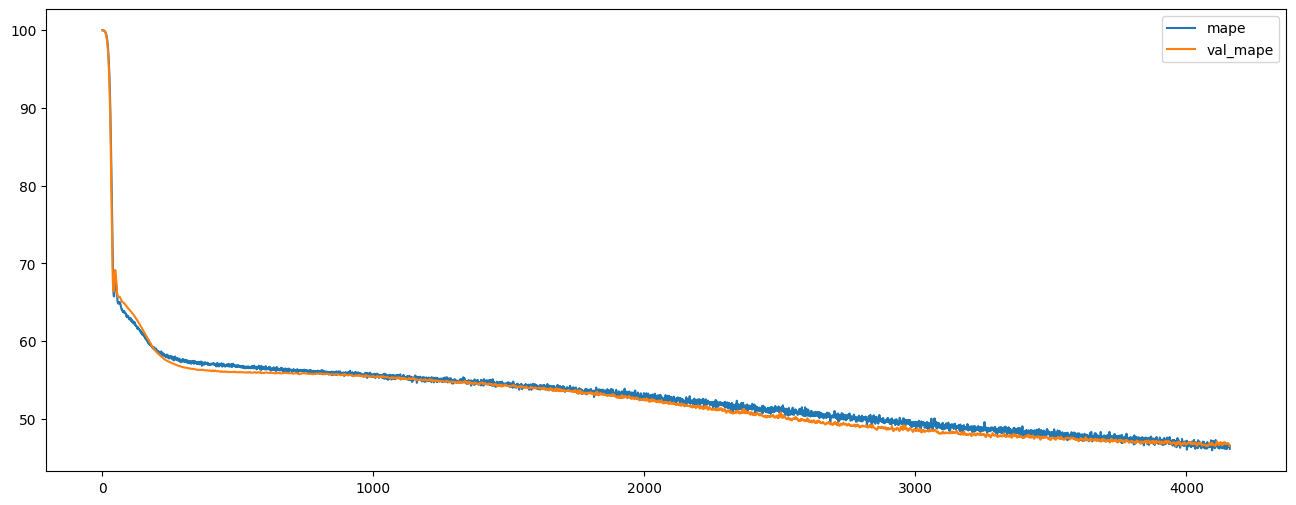

In [97]:
# retreina o modelo com os melhores hiperparâmetros
history = mlp_model.fit(
  features_train_nn,
  targets_train_nn,
  epochs=5500,
  batch_size=8000,
  validation_data=(features_val_nn, targets_val_nn),
  callbacks=[early_stopping], 
  verbose=0)
clear_output()
sns.lineplot(x=history.epoch, y=history.history['mean_absolute_percentage_error'], label='mape')
sns.lineplot(x=history.epoch, y=history.history['val_mean_absolute_percentage_error'], label='val_mape')
plt.show()

In [99]:
y = targets_train_nn
y_pred_val = mlp_model.predict(features_train_nn)
y_test = targets_test
y_pred = mlp_model.predict(data_test)
metrics = {
	'validation': {
		'mae': mean_absolute_error(y, y_pred_val),
		'rmse': np.sqrt(mean_squared_error(y, y_pred_val)),
		'median_error': median_absolute_error(y, y_pred_val),
		'r2': r2_score(y, y_pred_val),
		'mape': mean_absolute_percentage_error(y, y_pred_val),
		'gamma_deviance': mean_gamma_deviance(y, y_pred_val),
	},
	'test': {
		'mae': mean_absolute_error(y_test, y_pred),
		'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
		'median_error': median_absolute_error(y, y_pred_val),
		'r2': r2_score(y_test, y_pred),
		'mape': mean_absolute_percentage_error(y_test, y_pred),
		'gamma_deviance': mean_gamma_deviance(y_test, y_pred),
	}
}

validation = pd.DataFrame(metrics['validation'], index=['validation'])
test = pd.DataFrame(metrics['test'], index=['test'])
display(pd.concat([validation, test], axis=0).T)

model_mlp =  {
		'description': 'neural_network_mlp',
		'metrics': metrics,
		'estimator': mlp_model,
		'results': None,
		'predictions': y_pred,
	}

models[model_mlp['description']] = model_mlp

37/37 [==============================] - 0s 778us/step


,validation,test
mae,"104,556.8828","107,443.5938"
rmse,"304,067.4062","295,992.9062"
median_error,"12,502.4795","12,502.4795"
r2,-0.0203,-0.0410
mape,0.4449,0.4902
gamma_deviance,3.0060,3.2622


In [100]:
# salva o modelo
mlp_model.save('models/mlp_model.h5')

#### comparação de modelos

In [101]:
# plota a distribuição dos residuais
def plot_residuals_distribution (
		y_true: pd.DataFrame, 
		y_pred: pd.DataFrame, 
		title: str,
		pct: bool = False,
	) -> None:	
	if pct:
		y_pred = (y_pred - y_true)/y_true
	fig, axs = plt.subplot_mosaic([ ['R', 'R', 'R', 'D']],	figsize=(16, 6), constrained_layout=True, sharey=True)
	plt.suptitle(f"residuais {'percentuais ' if pct else ''}para {title}")
	plt.rcParams['figure.figsize'] = (16, 6)
	sns.residplot(x=y_true, y=y_pred, scatter_kws={'s':6, 'alpha':0.5, 'color':'black'}, 
		lowess=True, line_kws={'lw':1, 'alpha': 1, 'color': 'red'}, label='prediction', ax=axs['R'])
	sns.distplot(y_pred, bins=20, kde=True, color='grey', label='prediction', ax=axs['D'], vertical=True)
	if pct:
		plt.ylim(-3, 3)
	plt.xlabel('residuais')
	plt.ylabel('densidade')
	plt.legend()
	plt.show()

mae         rmse  median_error  \
regression_tree_risk validation  63,407.9429 158,396.5560   14,222.3013   
                     test        70,956.6759 167,120.8426   14,222.3013   
random_forests_risk  validation  23,210.7832  62,400.4023    5,449.7812   
                     test        47,141.1992 111,179.3828    5,449.7812   
xgboost_dart_risk    validation  22,145.4199  59,074.4922    6,078.9355   
                     test        43,572.4844 119,635.9688    6,078.9355   
neural_network_mlp   validation 104,556.8828 304,067.4062   12,502.4795   
                     test       107,443.5938 295,992.9062   12,502.4795   

                                     r2   mape  gamma_deviance  
regression_tree_risk validation  0.7161 0.7600          0.3446  
                     test        0.6682 0.9045          0.4827  
random_forests_risk  validation  0.9559 0.3147          0.0995  
                     test        0.8531 0.6879          0.2923  
xgboost_dart_risk    validation  0.9605 0.2467          0.0798  
                     test        0.8299 0.4416          0.3100  
neural_network_mlp   validation -0.0203 0.4449          3.0060  
                     test       -0.0410 0.4902          3.2622

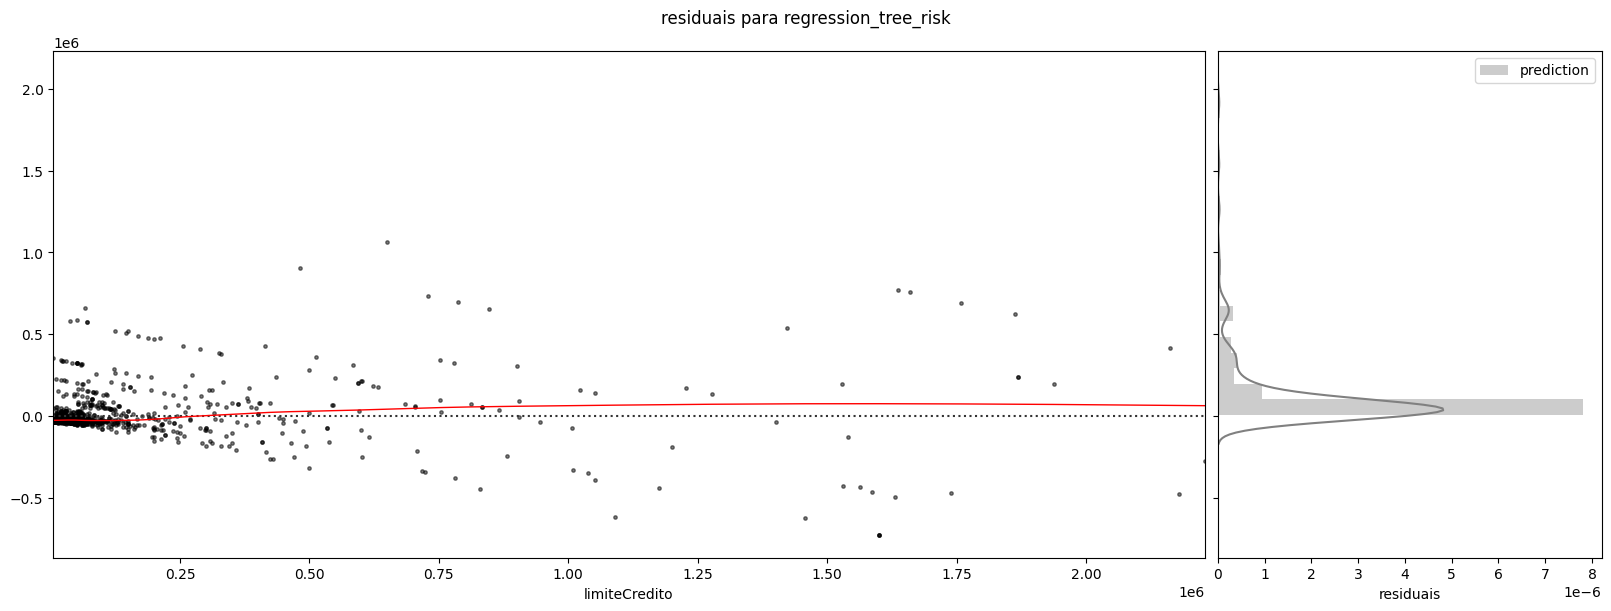

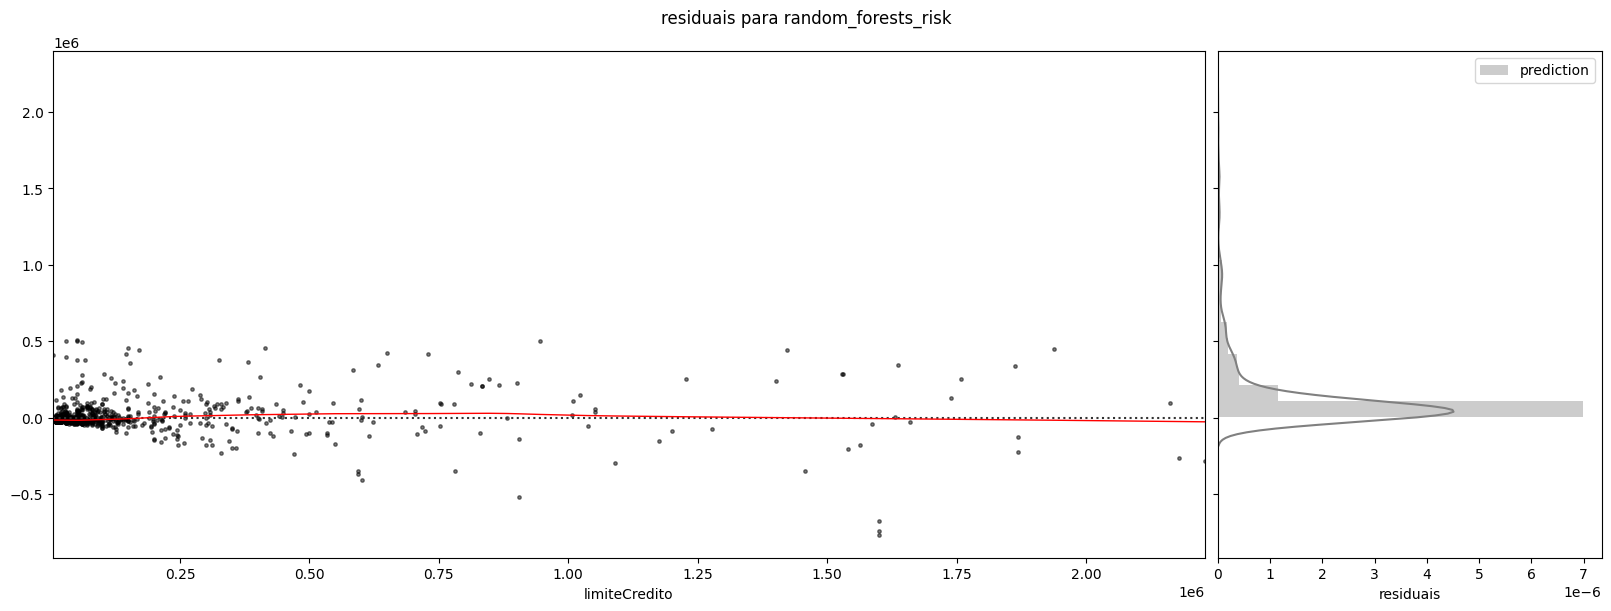

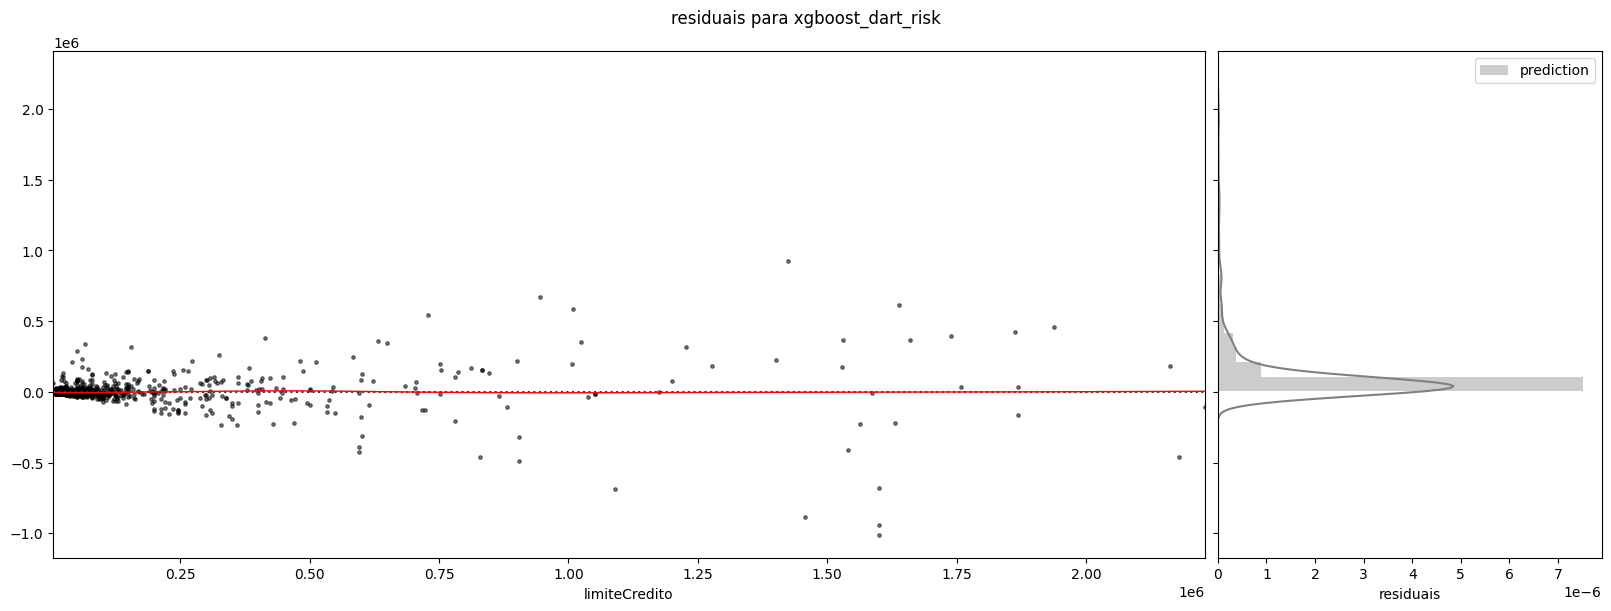

37/37 [==============================] - 0s 779us/step


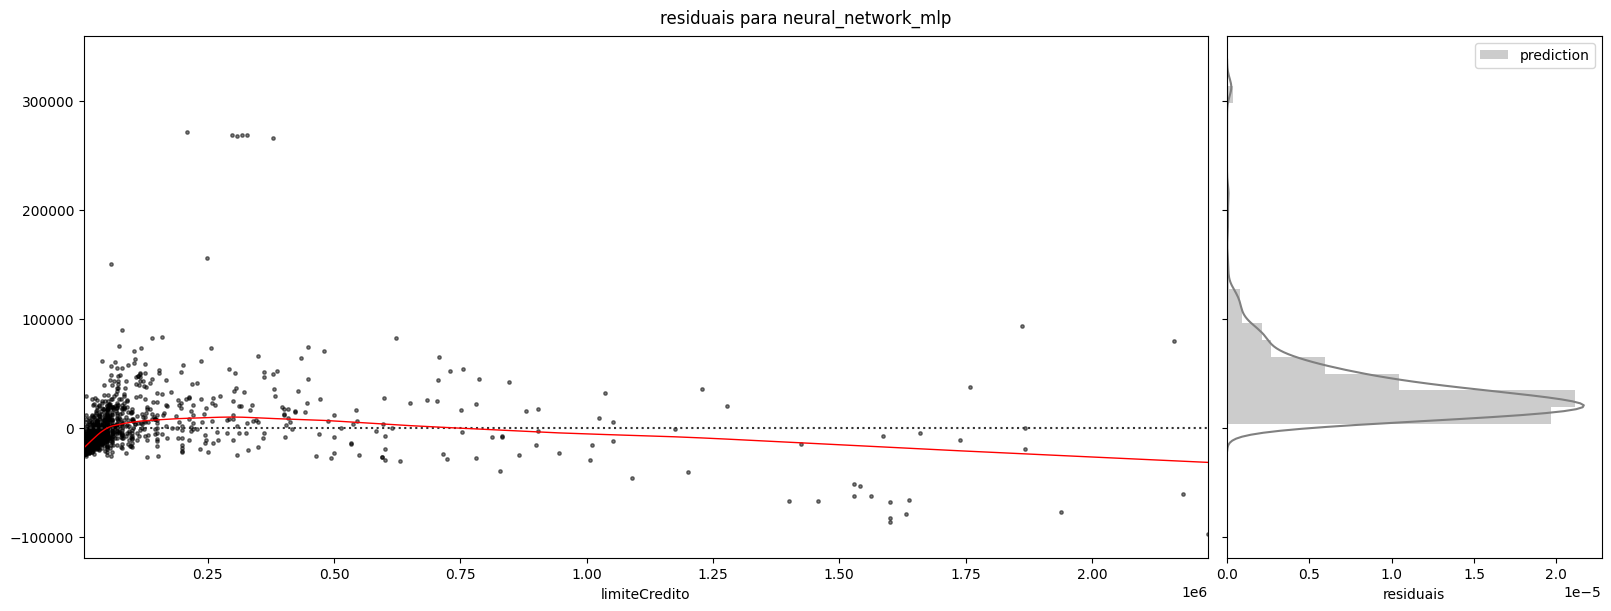

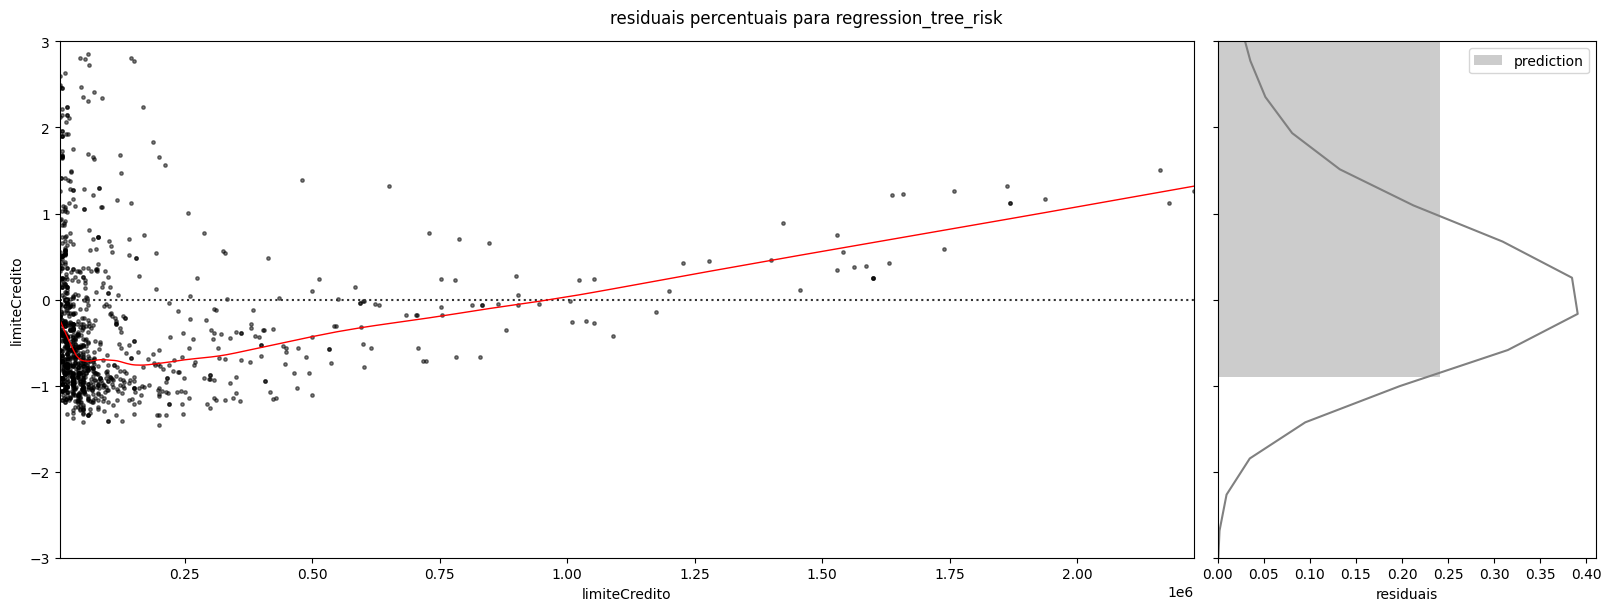

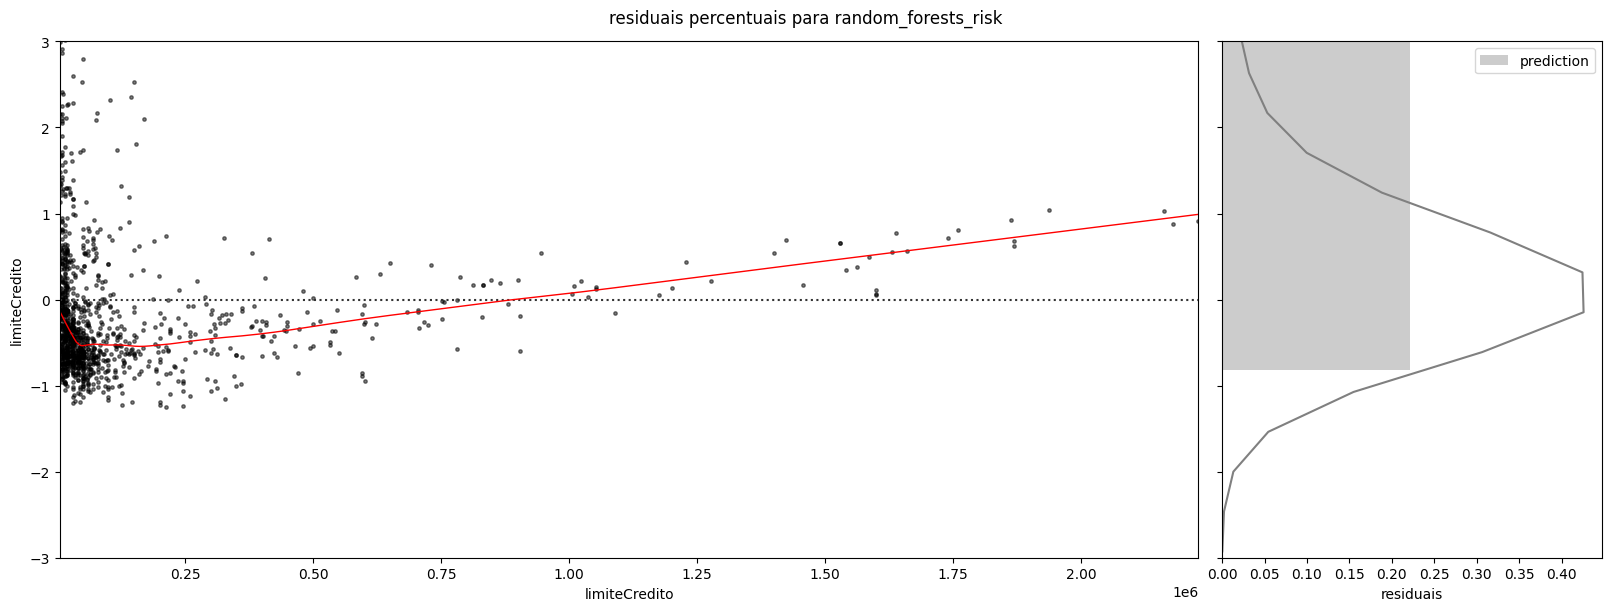

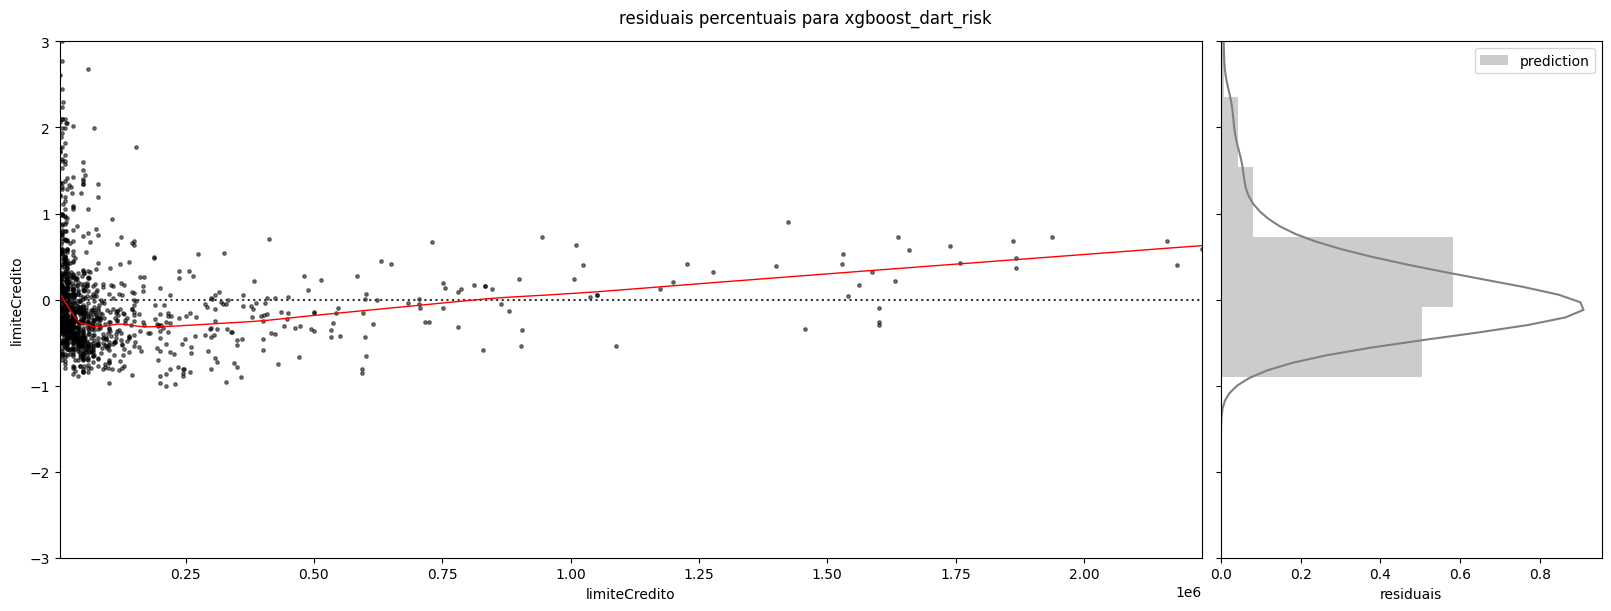

37/37 [==============================] - 0s 722us/step


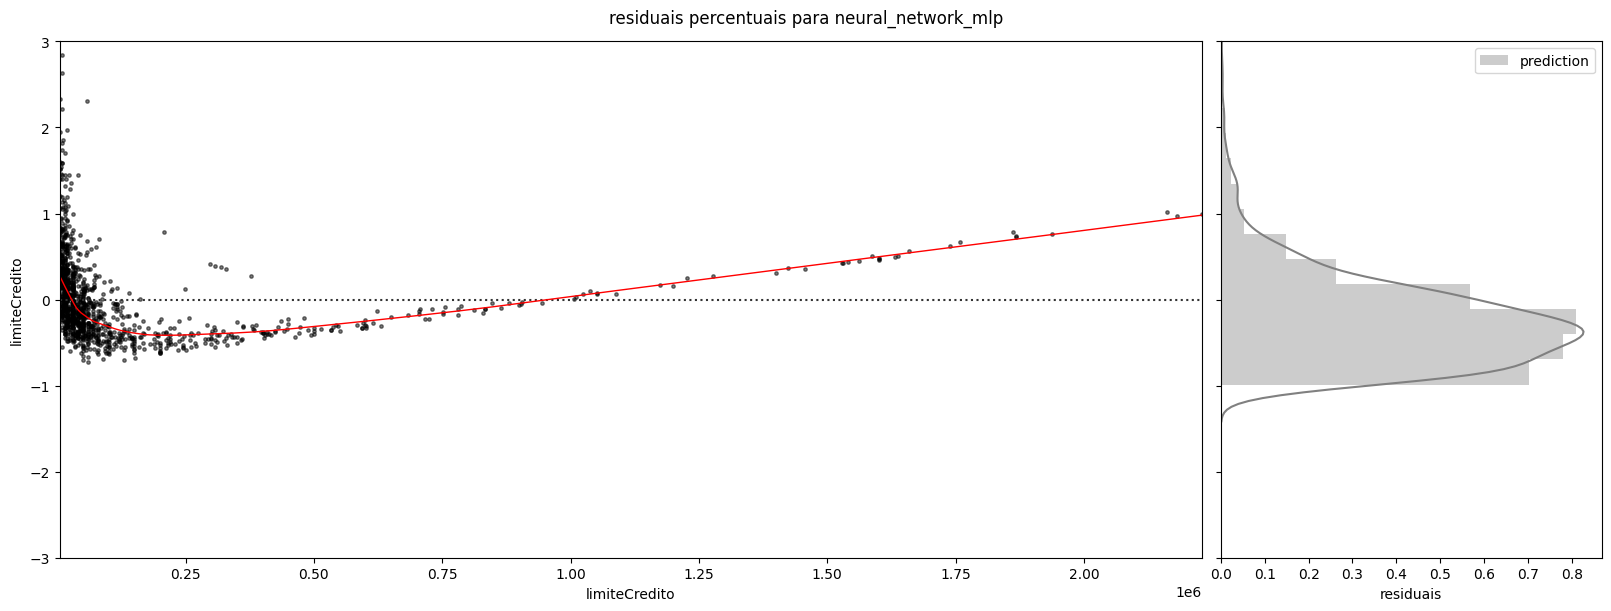

In [102]:
# compara os resultados entre os modelos
results = pd.DataFrame()
for model_name in models:
	model = models[model_name]
	validation = pd.DataFrame(model['metrics']['validation'], index=[[model['description']], ['validation']])
	test = pd.DataFrame(model['metrics']['test'], index=[[model['description']], ['test']])
	results = pd.concat([results, pd.concat([validation, test], axis=0)])

display (results)
# plota os graficos de residuais
for model_name in models:
	model = models[model_name]
	plot_residuals_distribution(targets_test, model['estimator'].predict(data_test).ravel(), title=model['description'])
	
for model_name in models:
	model = models[model_name]
	plot_residuals_distribution(targets_test, model['estimator'].predict(data_test).ravel(), title=model['description'], pct=True)


⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
A rede neural apresentou um MAPE de 43% na base teste e foi o modelo com melhor poder preditivo
</td></tr></table></div>

#### importância das features

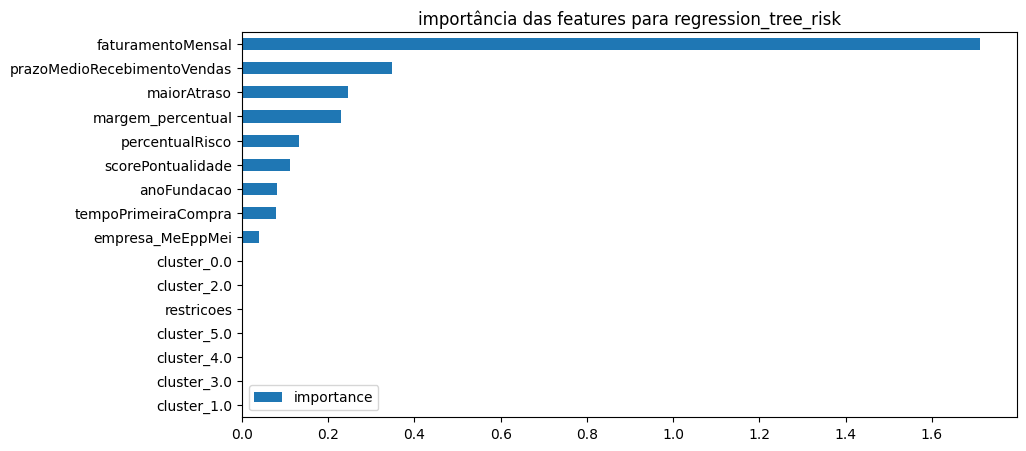

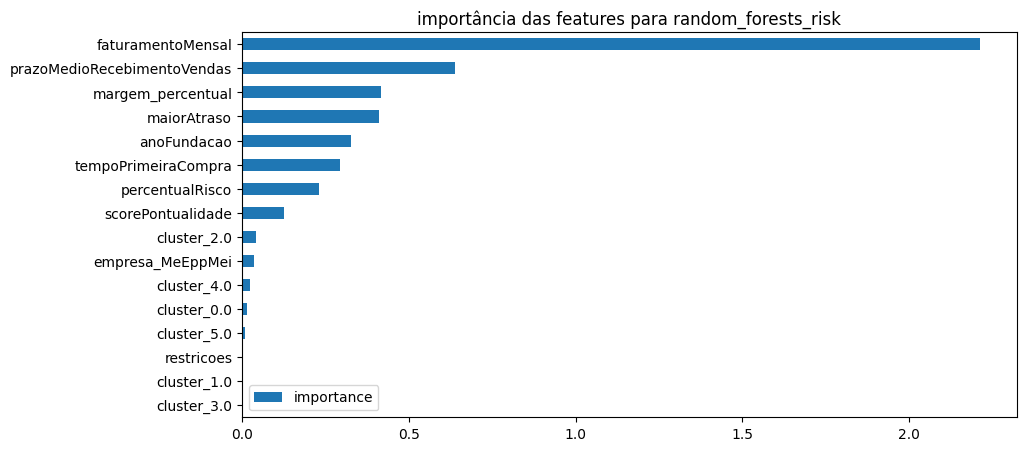

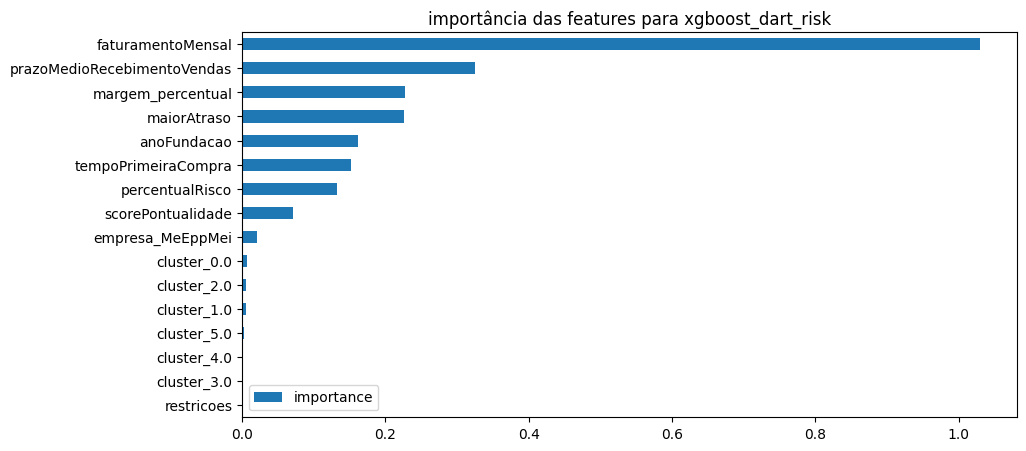

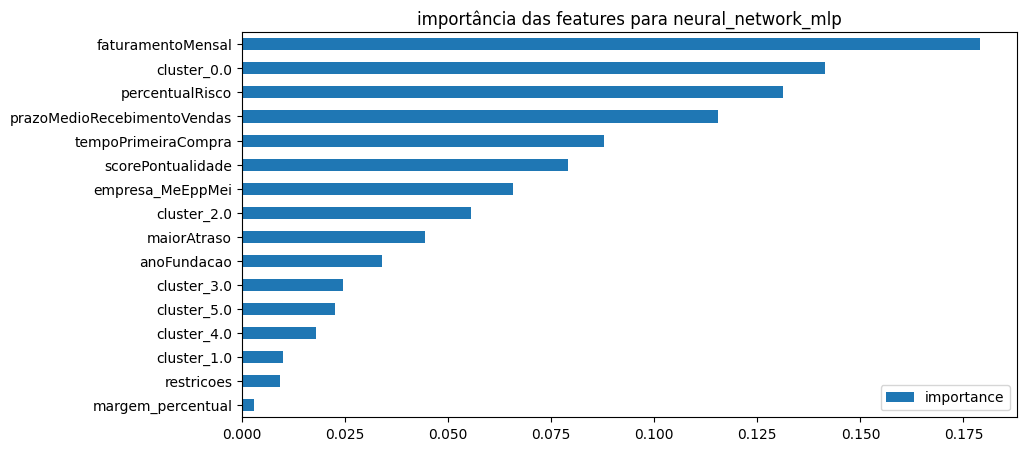

In [103]:
def plot_feature_importances(
		importances: pd.DataFrame,
		columns: list,
		) -> None:
	table = pd.DataFrame(importances.importances_mean, index=columns, columns=['importance'])
	table.sort_values(by='importance', ascending=True, inplace=True)
	table.plot.barh(figsize=(10, 3+int(table.shape[0]/6)))
	plt.title(f"importância das features para {model['description']}")
	plt.show()

for model_name in models:
	model = models[model_name]
	model['importances'] = permutation_importance(model['estimator'], data_train, targets_train, n_repeats=10, scoring='neg_mean_absolute_percentage_error')
clear_output()
for model_name in models:
	model = models[model_name]
	plot_feature_importances(importances=model['importances'], columns=data_train.columns)


### Conclusão

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
- A rede neural performou bem e fez um bom aproveitamento das features para as predições <br>
- No entanto com um erro percentual de 42%, ... <br>
- É necessário reavaliar a base de dados ...
</td></tr></table></div>